In [2]:
import SimpleITK as sitk
from subprocess import call
import os
from shutil import rmtree
def D4NifityReader(Filepath):
    tempD='./temp_D4N/'
    os.makedirs(tempD)
    call(['fslsplit',Filepath,tempD])
    D3Nifity=os.listdir(tempD)
    Result={n:sitk.ReadImage(os.path.join(tempD,i)) for n,i in enumerate(D3Nifity)}
    rmtree(tempD)
    return Result
#     return D3Nifity
    

In [3]:
import numpy as np

def ExtractValueFromMask(RawImage,MaskImage=None,ExtractFun=np.mean,CertainVox=[(0,0,0)]):
    RawArray=sitk.GetArrayFromImage(RawImage)
    
    result={}
    if MaskImage!=None:
        MaskArray=sitk.GetArrayFromImage(MaskImage)
        for i in set(MaskArray.flatten())-set([0]):
            
            Value=ExtractFun(RawArray[MaskArray==i])
            result['MaskIndex_'+str(i)]=Value
    if CertainVox!=[(0,0,0)]:
        for v in CertainVox:
            Value=RawArray[v]
            result['VoxLoc_'+'.'.join([str(i) for i in v])]=Value
    return result    

In [4]:
import xml.etree.cElementTree as et
parsedXML = et.parse('./data/HarvardOxford-Cortical.xml')
import pandas as pd
temp1=[]
for child in parsedXML.getroot():
    a=child.findall('label')
    if a!=[]:
        temp1.extend(a)
    

import re

n=0
ResultD={}
for i in temp1:
    ResultD[n]={'TemplateIndex':i.attrib['index'],'TemplateName':i.text}
    n+=1

TemplateNoteDf=pd.DataFrame(ResultD).T
TemplateNoteDf.head()

/Users/ningrongye/anaconda/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/Users/ningrongye/anaconda/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/Users/ningrongye/anaconda/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/Users/ningrongye/anaconda/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/Users/ningrongye/anaconda/lib/python2.7/site-packages/pandas/c

,TemplateIndex,TemplateName
0,0,Frontal Pole
1,1,Insular Cortex
2,2,Superior Frontal Gyrus
3,3,Middle Frontal Gyrus
4,4,"Inferior Frontal Gyrus, pars triangularis"


In [5]:
# TemplateNoteDf.TemplateIndex=TemplateNoteDf.TemplateIndex.astype(int)
TemplateNoteDf1=TemplateNoteDf.set_index('TemplateIndex')

TemplateNoteDf.index=TemplateNoteDf.index+1

In [6]:
AllFA=D4NifityReader(Filepath='./data/all_FA.nii.gz')


In [7]:
import numpy as np
def Mask2Template(RawMaskImage,TemplateImage,TemplateNoteDf):
    Result={}
    MaskArray=sitk.GetArrayFromImage(RawMaskImage)
    TemplateArray=sitk.GetArrayFromImage(TemplateImage)
    for i in set(MaskArray.flatten())-set([0]):
        temp=zip(*np.unique(TemplateArray[MaskArray==i], return_counts=True))
        for x,y in temp:
            try:
                Result.setdefault('MaskIndex_'+str(i),{}).update({TemplateNoteDf.loc[x,'TemplateName']:y})
            except:
                Result.setdefault('MaskIndex_'+str(i),{}).update({'NotInTemplate':y})
                
        
        
    return Result

In [8]:
RawMaskImage=sitk.ReadImage('./data/result_tfce_p_tstat1_SignIndex.nii.gz')
TemplateImage=sitk.ReadImage('./data/test_alignment_template.nii.gz')
  
ResultTest=Mask2Template(RawMaskImage=RawMaskImage,TemplateImage=TemplateImage,TemplateNoteDf=TemplateNoteDf)

In [9]:
PdLoc=pd.DataFrame(ResultTest)

In [203]:
PdLoc.to_excel('./MaskLocation.xlsx')

In [207]:
a=PdLoc.sum()

In [210]:
PdLoc1=PdLoc.T

In [211]:
PdLoc1.loc[:,'TotalVox']=a

In [216]:
PdLoc2=PdLoc1.sort_values('TotalVox',ascending=False)

In [231]:
PdLoc3=PdLoc2.iloc[:,[len(PdLoc2.columns)-1]+list(range(len(PdLoc2.columns)-2))]

In [233]:
PdLoc3.to_excel('./data/MaskLocation1.xlsx')

In [69]:
#MaskImage=sitk.ReadImage('./data/result_tfce_p_tstat1_SignIndex.nii.gz')

In [1]:
# RawSummary=pd.read_csv('../GX/test_fslresultsummary/result_tfce_p_tstat1_RawSummary.txt',sep='\t')

# RawSummary.columns

# VoxList=[(RawSummary.loc[i,'MAX X (vox)'],RawSummary.loc[i,'MAX Y (vox)'],RawSummary.loc[i,'MAX Z (vox)']) for i in RawSummary.index]

In [10]:
import pandas as pd
ResultD={}
for i in AllFA.keys():
    ResultD[i]=ExtractValueFromMask(RawImage=AllFA[i],MaskImage=RawMaskImage)#,CertainVox=VoxList
ResultDf=pd.DataFrame(ResultD)

In [11]:
HeadInform=pd.read_excel('./data/HeadInform.xlsx')

In [236]:
# HeadInform.head()

In [14]:
a=HeadInform.ScanTime-HeadInform.DOBTime

9.055555555555555

In [19]:
# HeadInform.loc[:,'DOBTime']=pd.to_datetime(HeadInform.DOB_0010_0030,format='%Y%m%d')
# HeadInform.loc[:,'ScanTime']=pd.to_datetime(HeadInform.StudyDate_0008_0020,format='%Y%m%d')

HeadInform.loc[:,'Age']=[i.days/360.0 for i in a]

In [204]:
HeadInform.to_excel('./data/HeadInform.xlsx')

In [20]:
DTI_Above4=HeadInform.loc[(HeadInform.Age>=4)&(HeadInform.SeriesGroup=='DTI'),['Age','StudyID','PatientGroup','Gender_0010_0040']]

In [21]:
DTI_Above4Use=DTI_Above4.sort_values('StudyID').reset_index().drop('index',axis=1)

In [22]:
DTI_Above4Use.head()

,Age,StudyID,PatientGroup,Gender_0010_0040
0,13.450000,StudyID_001,Normal,M
1,6.366667,StudyID_003,Normal,M
2,11.891667,StudyID_004,CSNHL,F
3,8.300000,StudyID_006,CSNHL,M
4,7.694444,StudyID_007,Normal,F


In [23]:
ResultDfUse=ResultDf.T.join(DTI_Above4Use)

In [28]:
ResultDfUse.columns[:-4]

Index([u'MaskIndex_1', u'MaskIndex_10', u'MaskIndex_100', u'MaskIndex_101',
       u'MaskIndex_102', u'MaskIndex_103', u'MaskIndex_104', u'MaskIndex_105',
       u'MaskIndex_106', u'MaskIndex_107',
       ...
       u'MaskIndex_90', u'MaskIndex_91', u'MaskIndex_92', u'MaskIndex_93',
       u'MaskIndex_94', u'MaskIndex_95', u'MaskIndex_96', u'MaskIndex_97',
       u'MaskIndex_98', u'MaskIndex_99'],
      dtype='object', length=473)

In [30]:
set(HeadInform.PatientGroup)

{u'CSNHL', u'Normal'}

In [31]:
'aaa'.split('_')

['aaa']

In [35]:
from scipy import stats
def UnivariateCor(X,y,Group='ContinueVar'):
    if Group=='ContinueVar':
        cor,p=stats.pearsonr(X,y)
        Result={'Var':'ContinueVar','p':p,'Statistic':cor,'Method':'Peason'}
    elif Group=='Nominal':
        stat,p=stats.f_oneway(*[np.array(X)[np.array(y)==i] for i in set(y)])
        Result={'Var':'Nominal','p':p,'Statistic':stat,'Method':'ANOVA'}
    else:
        print "Group= ContinueVar or Nominal"
    return Result
Result={}
for i in ResultDfUse.columns[:-4]:
    for g in ['CSNHL', u'Normal','CSNHL_Normal']:
        for yval,G in [('Age','ContinueVar'),('PatientGroup','Nominal'),('Gender_0010_0040','Nominal')]:
            grouping=ResultDfUse.PatientGroup.isin(g.split('_'))
            Result[(i,g,yval)]=UnivariateCor(X=ResultDfUse.loc[grouping,i],y=ResultDfUse.loc[grouping,yval],Group=G)


In [117]:
ResultDf1=pd.DataFrame(Result).T.reset_index()

In [118]:
ResultDf1.columns

Index([u'level_0', u'level_1', u'level_2', u'Method', u'Statistic', u'Var',
       u'p'],
      dtype='object')

In [124]:
ResultDf1.to_excel('./RawStd.xlsx')

In [175]:
ResultDf1.rename(columns={'level_0':'Cluster','level_1':'PatientGroup','level_2':'Comparison'},inplace=True)

In [186]:
AgeRelatedALL=ResultDf1.loc[(ResultDf1.Comparison=='Age'),['Cluster','PatientGroup','Statistic']]

In [182]:
# AgeRelatedALL.rename(columns={'Statistic':'PeasonCorrelationIndex'},inplace=True)

In [187]:
AgeRelatedALL.head()

,Cluster,PatientGroup,Statistic
0,MaskIndex_1,CSNHL,-0.311435
3,MaskIndex_1,CSNHL_Normal,-0.281048
6,MaskIndex_1,Normal,-0.230602
9,MaskIndex_10,CSNHL,-0.415377
12,MaskIndex_10,CSNHL_Normal,-0.280634


In [188]:
AgeRelated_HeatMap=AgeRelatedALL.set_index(['Cluster','PatientGroup']).unstack('PatientGroup')[temp.p]

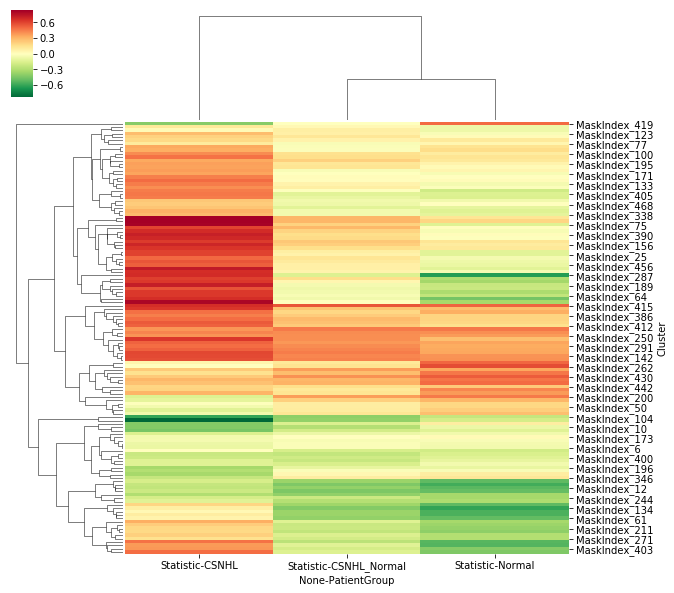

In [200]:
import seaborn as sns
sns.clustermap(AgeRelated_HeatMap.fillna(0),cmap='RdYlGn_r')#RdYlBu_r
plt.show()

In [159]:
temp=ResultDf1.loc[~ResultDf1.p.isna(),['level_0','p']].groupby(['level_0']).agg(lambda x:any([i<0.05 for i in x]))

In [160]:
temp.head()

,p
level_0,
MaskIndex_1,False
MaskIndex_10,True
MaskIndex_100,True
MaskIndex_101,False
MaskIndex_102,False


In [161]:
temp1=temp.index[temp.p]

In [127]:
AgeRelated=ResultDf1[(ResultDf1.p<0.05) & (ResultDf1.Method=='Peason')]

In [132]:
ResultDfUse.head()

,MaskIndex_1,MaskIndex_10,MaskIndex_100,MaskIndex_101,MaskIndex_102,MaskIndex_103,MaskIndex_104,MaskIndex_105,MaskIndex_106,MaskIndex_107,...,MaskIndex_94,MaskIndex_95,MaskIndex_96,MaskIndex_97,MaskIndex_98,MaskIndex_99,Age,StudyID,PatientGroup,Gender_0010_0040
0,0.242858,0.455630,0.317929,0.367121,0.194540,0.958776,0.466114,0.289961,0.317022,0.191329,...,0.226748,0.306852,0.325517,0.326806,0.151938,0.627897,13.450000,StudyID_001,Normal,M
1,0.403639,0.209183,0.211103,0.218346,0.211384,0.871483,0.400856,0.207521,0.310175,0.318257,...,0.229538,0.309924,0.311805,0.233704,0.185379,0.477563,6.366667,StudyID_003,Normal,M
2,0.297543,0.314945,0.341054,0.372296,0.418051,0.943446,0.387207,0.164505,0.226616,0.274385,...,0.281126,0.375302,0.164281,0.122878,0.180678,0.576658,11.891667,StudyID_004,CSNHL,F
3,0.205231,0.493740,0.405232,0.206333,0.103903,0.791407,0.591602,0.152321,0.103027,0.142776,...,0.379162,0.464324,0.174504,0.214633,0.301735,0.549020,8.300000,StudyID_006,CSNHL,M
4,0.172555,0.487061,0.287558,0.241742,0.081374,0.918819,0.494353,0.171263,0.352889,0.187503,...,0.246780,0.368826,0.339941,0.314606,0.098370,0.526995,7.694444,StudyID_007,Normal,F


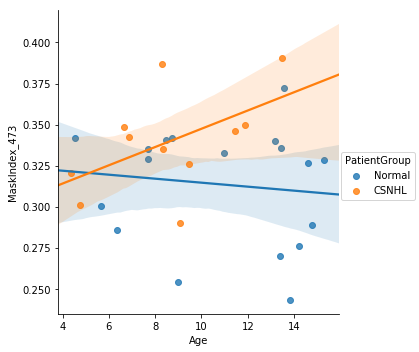

In [234]:
g = sns.lmplot(x="Age", y='MaskIndex_473', hue="PatientGroup", data=ResultDfUse)
plt.show()

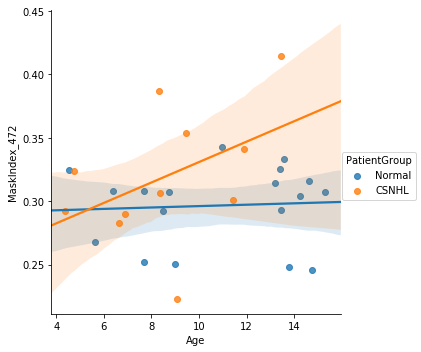

In [235]:
g = sns.lmplot(x="Age", y='MaskIndex_472', hue="PatientGroup", data=ResultDfUse)
plt.show()

MaskIndex_262


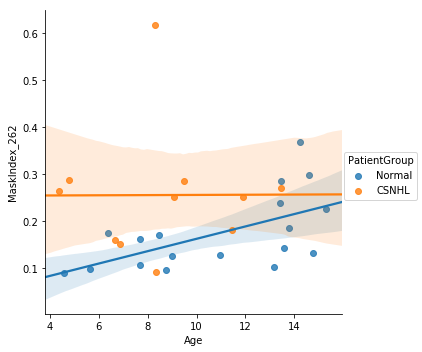

MaskIndex_263


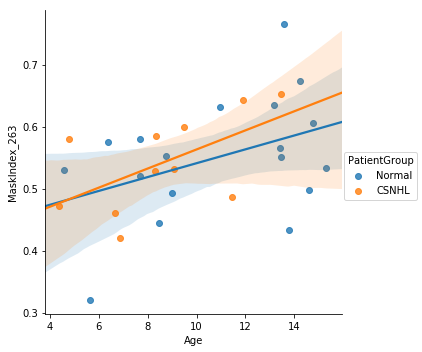

MaskIndex_449


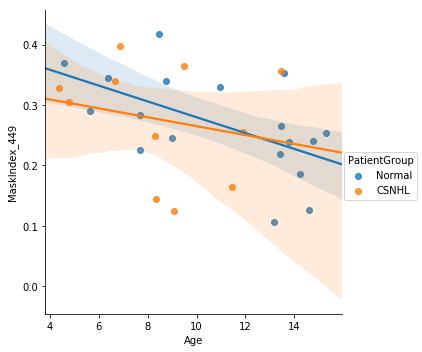

MaskIndex_447


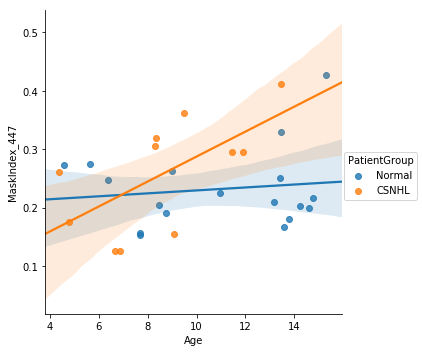

MaskIndex_291


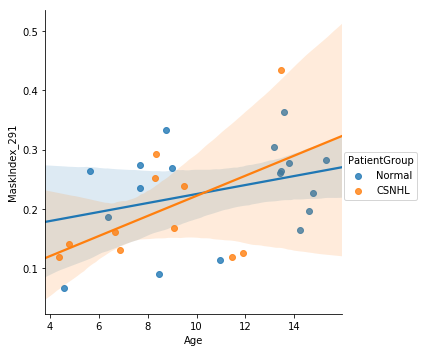

MaskIndex_420


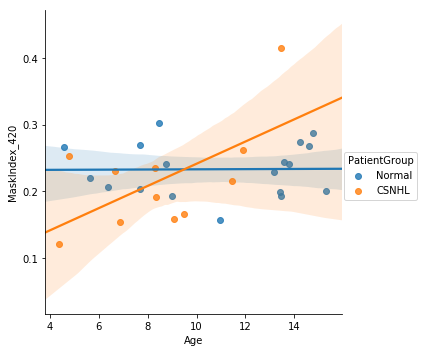

MaskIndex_421


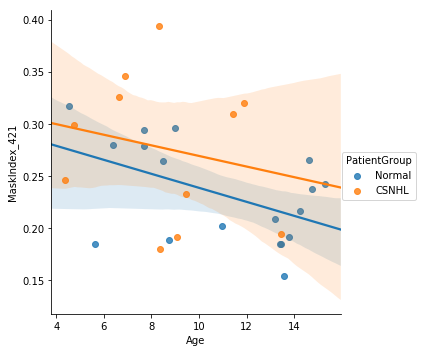

MaskIndex_426


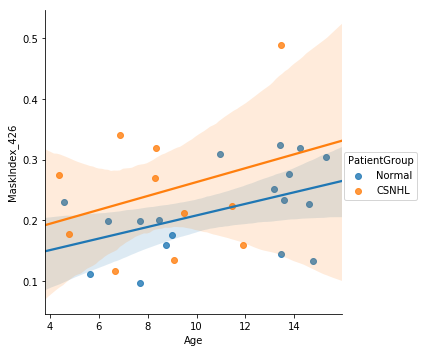

MaskIndex_223


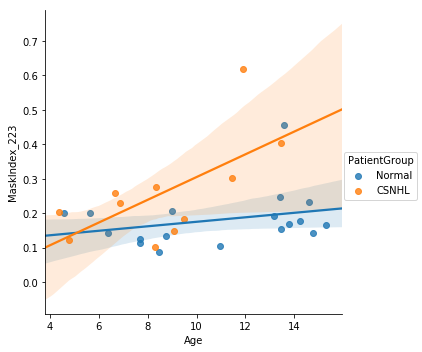

MaskIndex_206


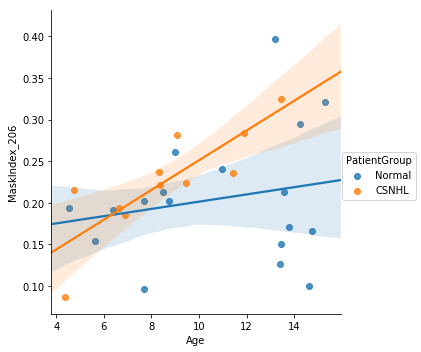

MaskIndex_429


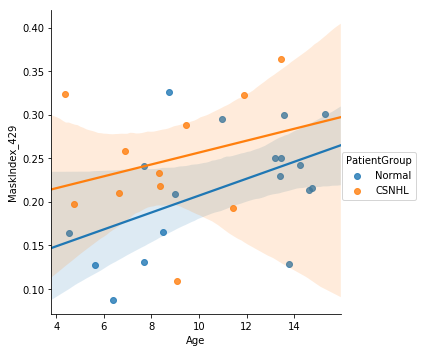

MaskIndex_200


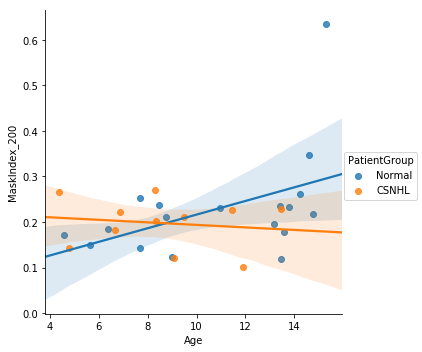

MaskIndex_311


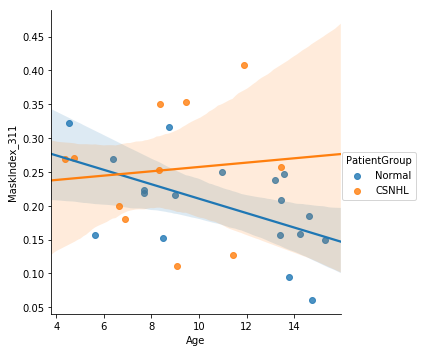

MaskIndex_189


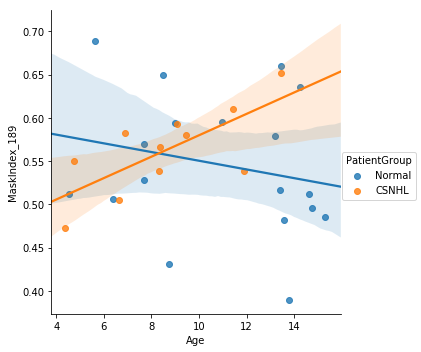

MaskIndex_188


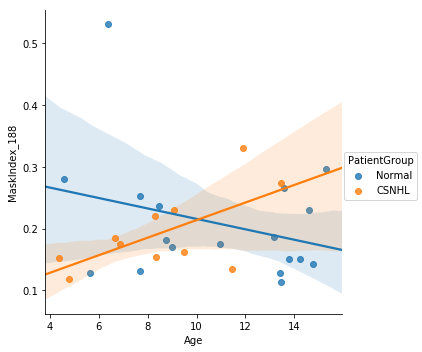

MaskIndex_43


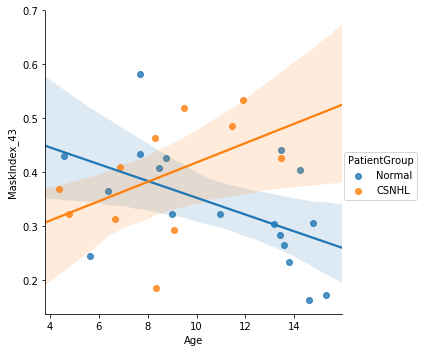

MaskIndex_142


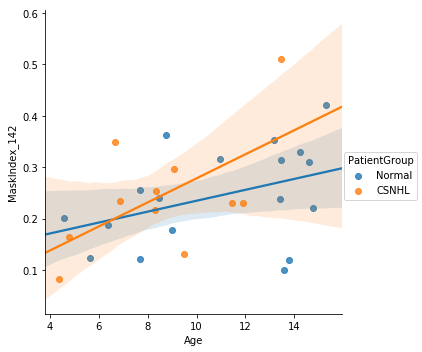

MaskIndex_364


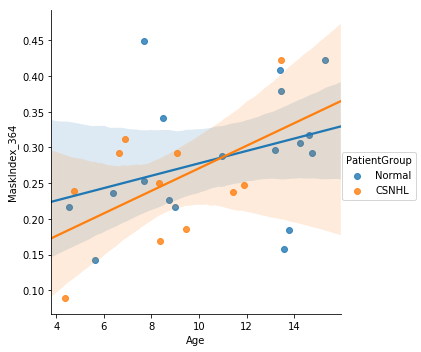

MaskIndex_440


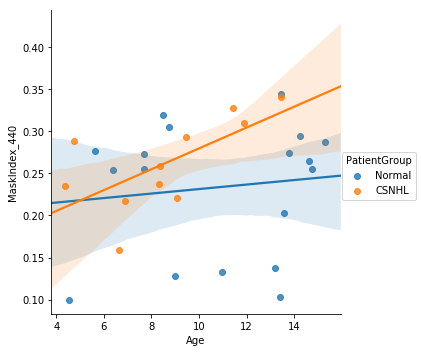

MaskIndex_104


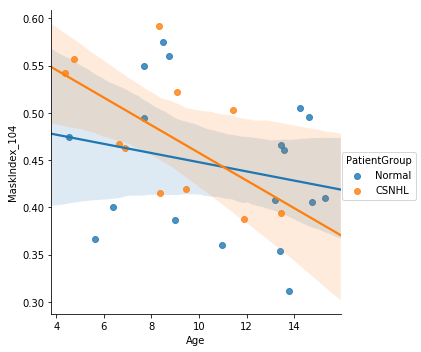

MaskIndex_120


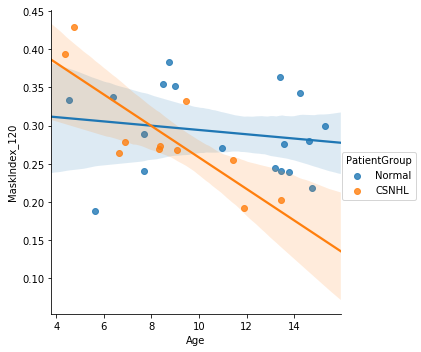

MaskIndex_51


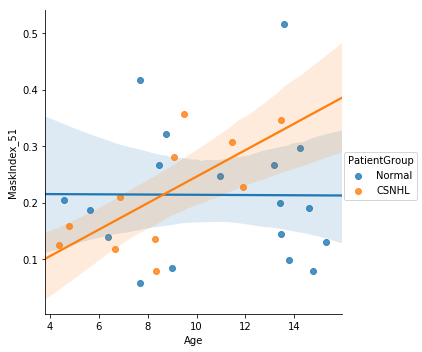

MaskIndex_9


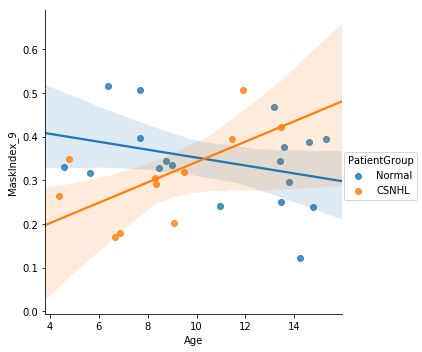

MaskIndex_56


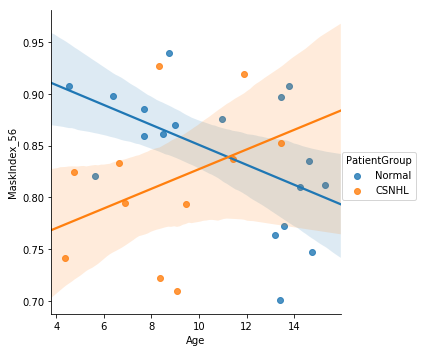

MaskIndex_399


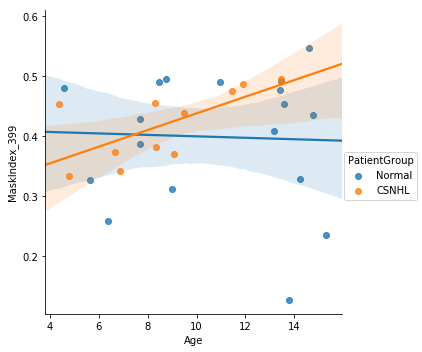

MaskIndex_58


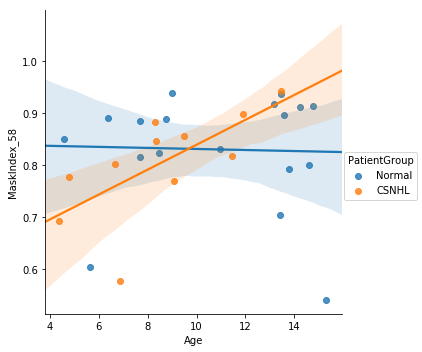

MaskIndex_15


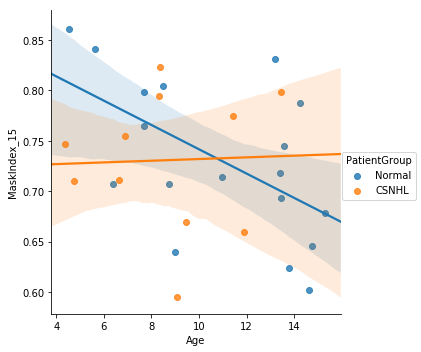

MaskIndex_12


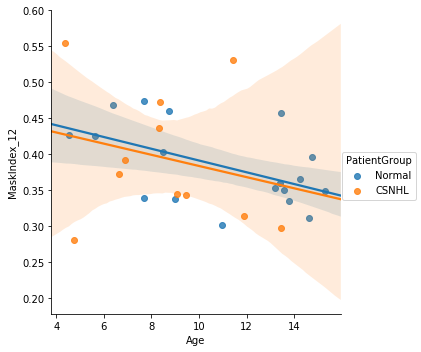

MaskIndex_390


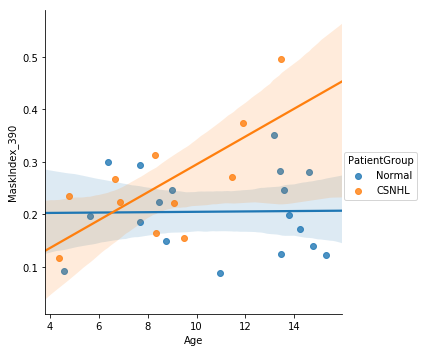

MaskIndex_152


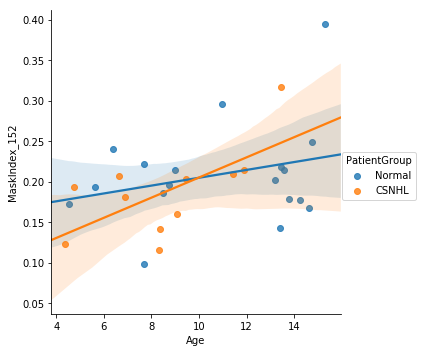

MaskIndex_415


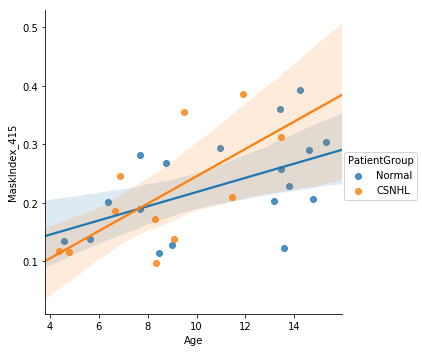

MaskIndex_393


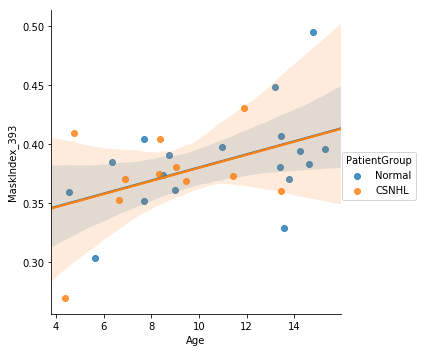

MaskIndex_394


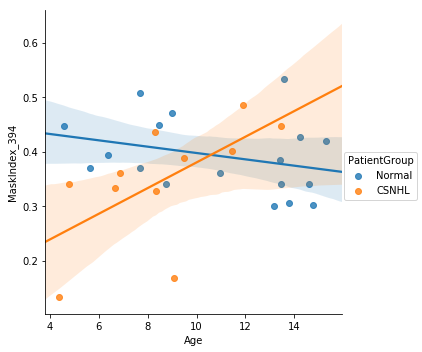

MaskIndex_69


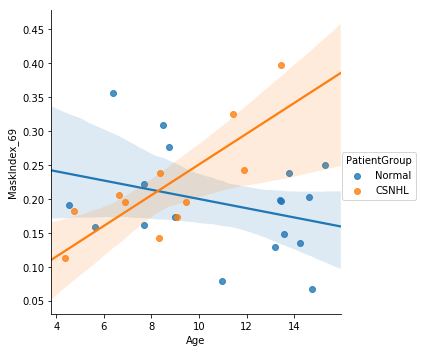

MaskIndex_250


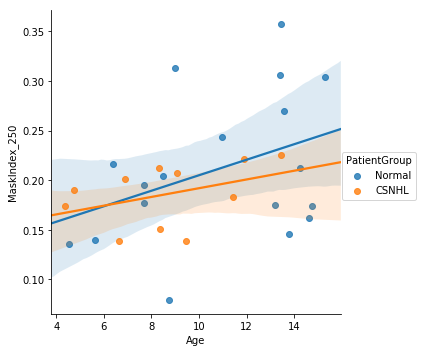

MaskIndex_64


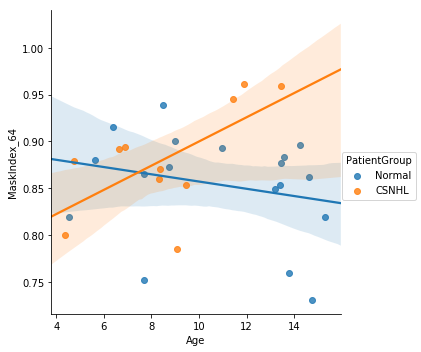

MaskIndex_419


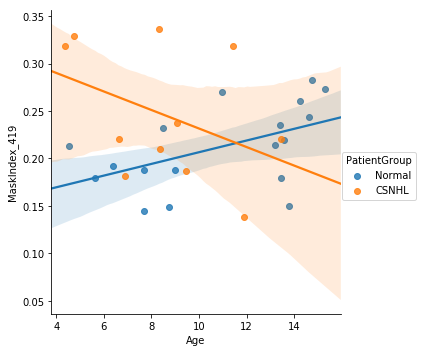

MaskIndex_418


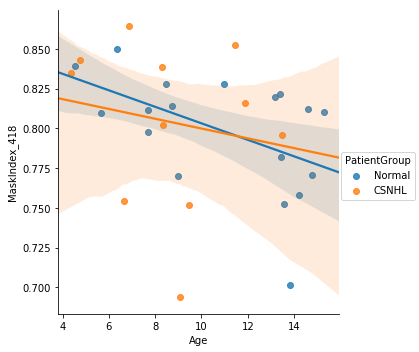

MaskIndex_193


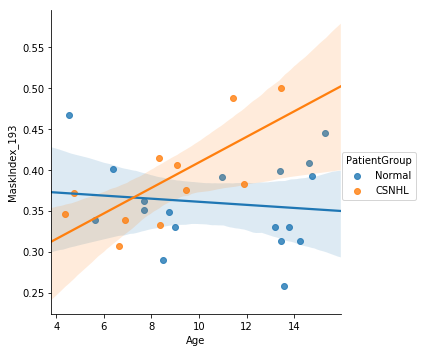

MaskIndex_59


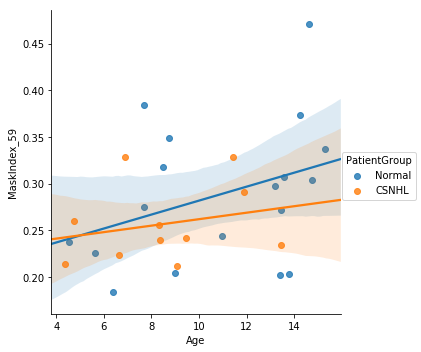

MaskIndex_299


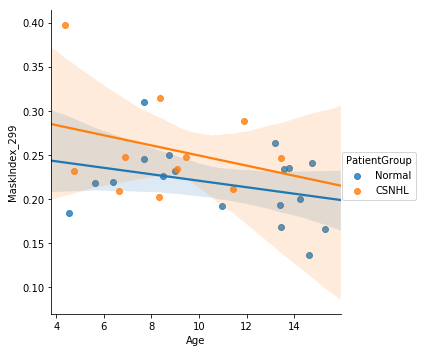

MaskIndex_172


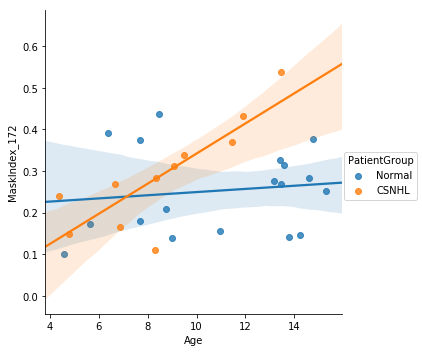

MaskIndex_430


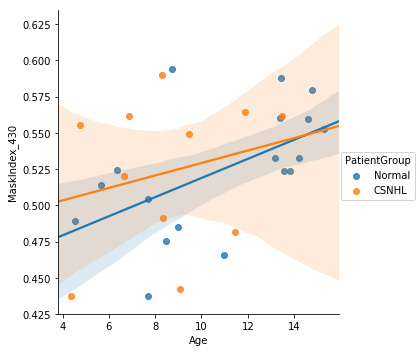

MaskIndex_317


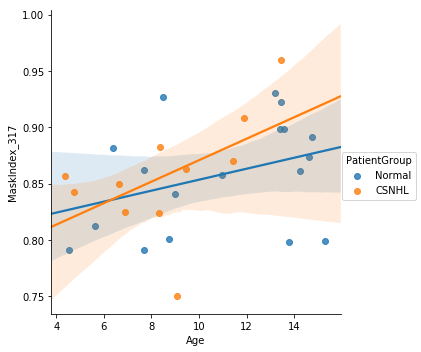

MaskIndex_134


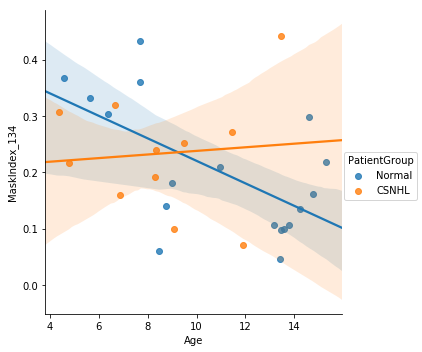

MaskIndex_150


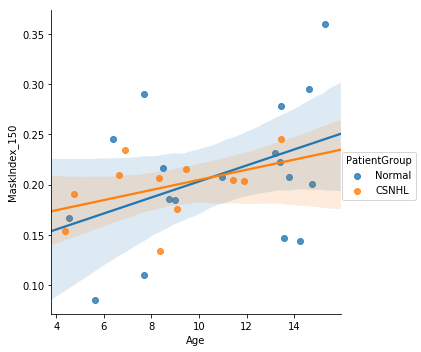

MaskIndex_156


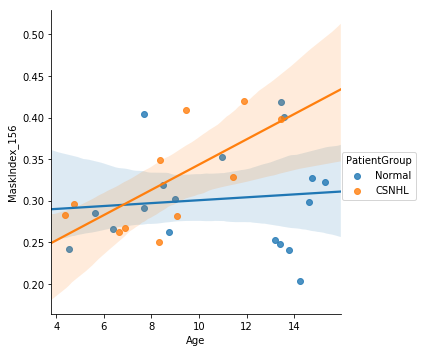

MaskIndex_298


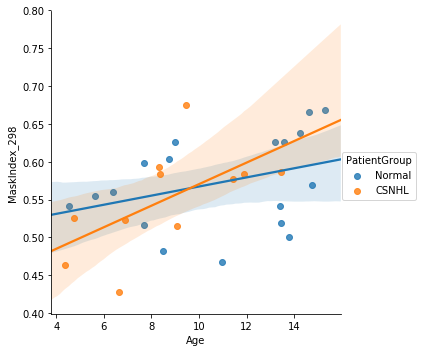

MaskIndex_61


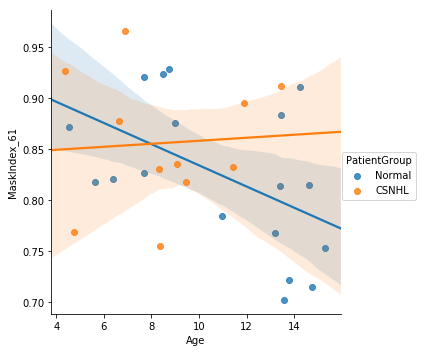

MaskIndex_158


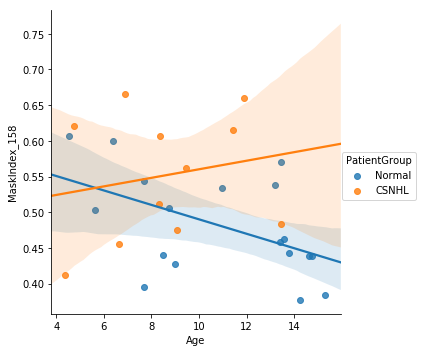

MaskIndex_138


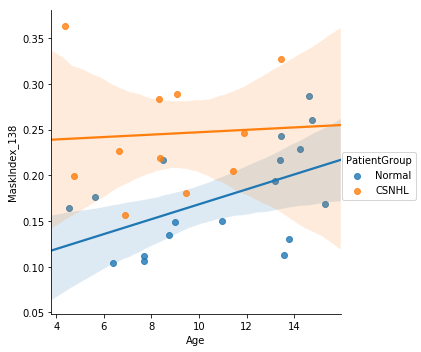

MaskIndex_328


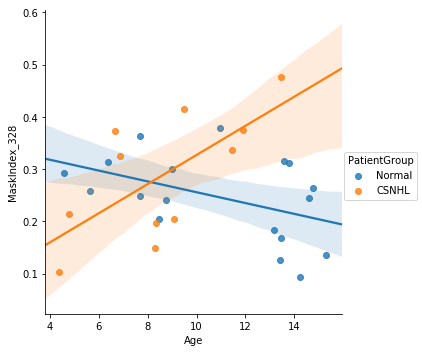

MaskIndex_110


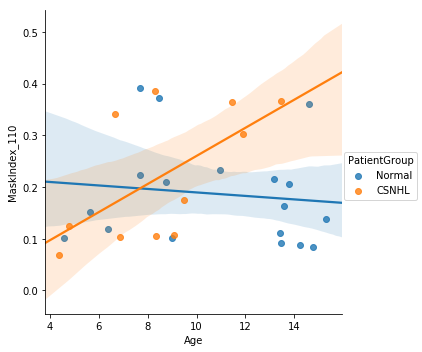

MaskIndex_25


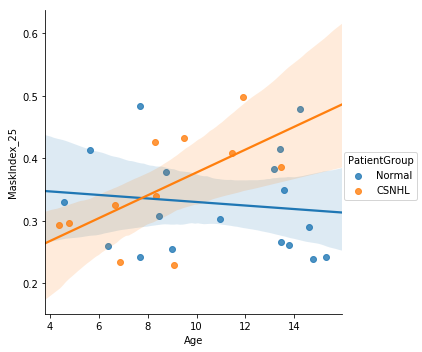

MaskIndex_46


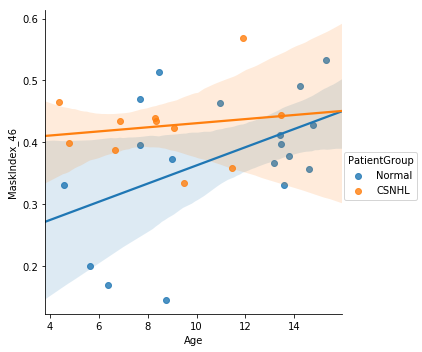

MaskIndex_287


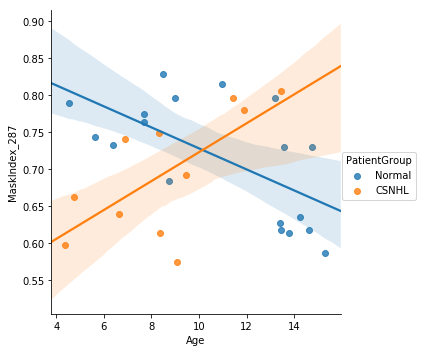

MaskIndex_75


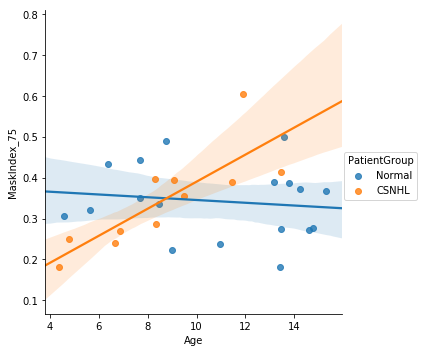

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in set(AgeRelated.level_0):
    print i
    g = sns.lmplot(x="Age", y=i, hue="PatientGroup", data=ResultDfUse)
    plt.show()